In [71]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [72]:
# get input data
deepmimo = False
sequence = True

function_folder = "seq_sin_pink_39.63"

data = CreateInput(function_folder, True)

tensors = data.get_tensors()

             0         1          2          3          4          5  \
0    -3.177501  9.927393   5.681799  -7.638065  11.136088   6.801421   
1     4.280241  6.535076  14.386076   2.176442   1.005072   0.274459   
2     0.142366  4.070378  -3.445773   4.423674   9.513393   0.261577   
3     5.672870 -3.777670   1.400050  12.318883   0.454172  -1.354323   
4    -0.424351 -7.162302   4.701652  -1.212968  11.209600   4.739878   
..         ...       ...        ...        ...        ...        ...   
135  -5.965864 -5.317521  -1.038519  -7.467142  -7.210137  -3.106335   
136   5.816227 -8.687439  -2.521201  -6.383102  -5.026527   3.346995   
137 -12.584292  3.003530   2.479234  -1.676875   0.473884   1.478692   
138   1.862416  1.947698   2.144926   2.039426  13.051176 -11.141612   
139   0.542110 -8.712997   0.846128   9.936335  -5.450264  -1.412743   

             6          7          8          9  ...       1014      1015  \
0     3.616096  -5.153597   1.068061  18.315869  ...  -8.2

In [73]:
tensors['train'][1].shape

torch.Size([140, 1024])

# Evaluate KAN

In [74]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

input_size = tensors['test'][1].shape[1]

if sequence:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 2*input_size + 1, input_size],
                       [input_size, 20, input_size], [input_size, 20, 20, input_size], [input_size, 20, 20, 20, input_size],
                       [input_size, 10, input_size],
                       [input_size, 5, input_size],
                       [input_size, 20, 10, 20, input_size], [input_size, 10, 5, 10, input_size]], 
        'kan__grid': [3, 5],
        'kan__k': [3, 5],
        'kan__seed': [42],
        'kan__lr': [0.01],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [10]
    }

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }



# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
if not deepmimo:
    grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

    # Retrieve the best parameters and best score
    grid_search.best_params_['kan__data'] = []          # remove annoying print
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    opt_params_KAN = grid_search.best_params_


In [75]:
# evaluate KAN with optimal params
if not deepmimo:
    kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=100, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

In [76]:
if deepmimo:
    kan_model = KANModel(width=[1024, 500, 1024], grid=10, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,epochs=10, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()
results = {}
results["test_loss"] = y_preds['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.72e-02 | test_loss: 3.06e-01 | reg: 5.16e+03 | : 100%|█| 10/10 [13:09<00:00, 78.94s/


saving model version 0.1


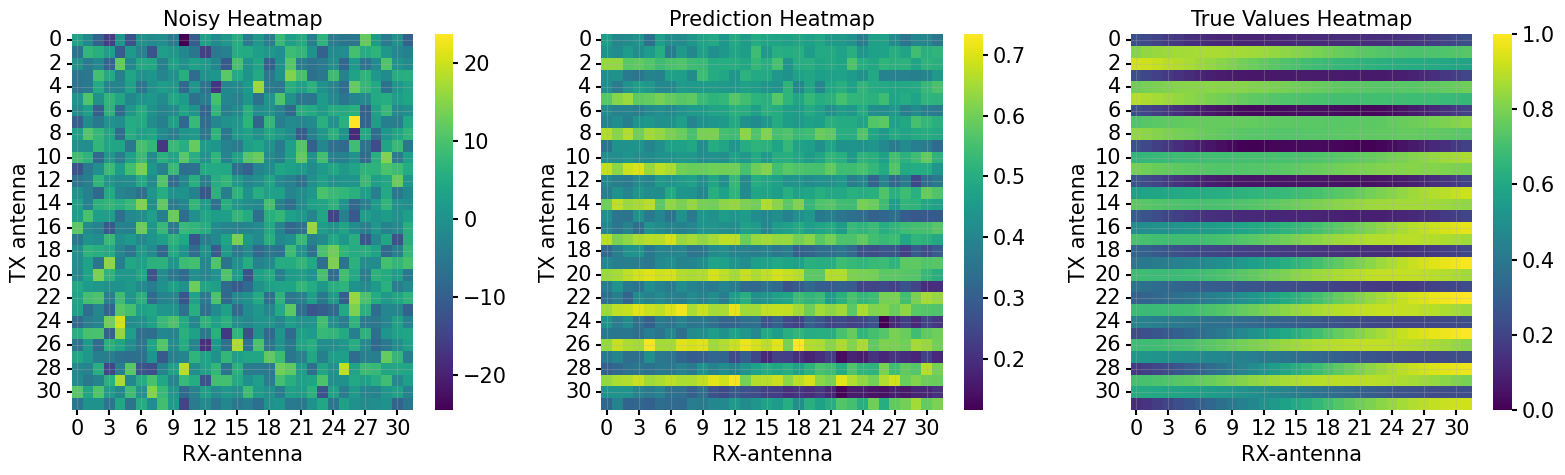

In [77]:
# plot pred and true
if deepmimo:
    noisy_sample = tensors['test'][0][5]
    pred_sample = y_preds['preds'][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo_with_noise(true_sample=true_sample, pred_sample=pred_sample,noisy_sample=noisy_sample, save=False)
else:
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [78]:
if deepmimo:
    num_samples = tensors['test'][0].shape
    noisy = tensors['test'][0] # [20, 1024]
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((noisy-true)**2, axis=1))
    print(f"Average MSE per sample between noisy and true: {average_mse}")
    results['noise-average-mse'] = average_mse

Average MSE per sample between noisy and true: 42715.9296875


In [79]:
# diffrence pred and true
if deepmimo:
    num_samples = tensors['test'][0].shape
    preds = y_preds['preds']
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
    print(f"Average MSE per sample between predicted and true for KAN: {average_mse}")
    results['pred-average-mse'] = average_mse
    #kan_model.write_params_to_file(results)

Average MSE per sample between predicted and true for KAN: 95.8275146484375
Model parameters saved to ./results/KAN/deepmimo-gaussian_-20.444/model_params.txt


saved loss to  ./results/KAN/deepmimo-gaussian_-20.444/loss.png


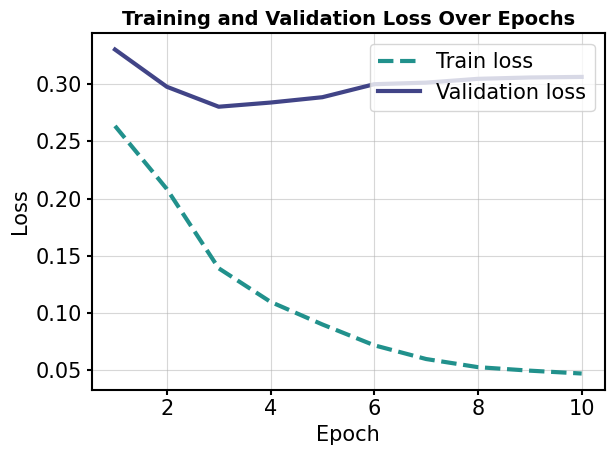

In [80]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [81]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[1000],[300,300,300],[128,128], [2000]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__lr': [0.01,0.1,0.001],
        'mlp__deepmimo': [True]
    }
else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[2*input_size + 1],
                       [20], [20, 20], [20, 20, 20],
                       [10],
                       [5],
                       [20, 10, 20], [10, 5, 10]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [10],
        'mlp__deepmimo': [True],
        'mlp__lr': [0.01]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    #('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_ = torch.tensor(X).float()
/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/Users/hampusf/Documents/SCHOOL/DD2434/pink_noise_branch/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

Best Parameters: {'mlp__output_size': 1024, 'mlp__lr': 0.001, 'mlp__input_size': 1024, 'mlp__hidden_size': [64, 64], 'mlp__epochs': 100, 'mlp__deepmimo': True, 'mlp__data': []}
Best Cross-Validation Score: -19.97094554901123


In [90]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'],result_path=f"./results/MLP/{function_folder}", lr=opt_params_MLP['mlp__lr'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=50, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)
results = {}
results['test_loss'] = y_preds_MLP['test_loss']

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [91]:
# diffrence pred and true for MLP
if deepmimo:
    num_samples = tensors['test'][0].shape        
    preds = y_preds_MLP['preds']
    true = tensors['test'][1]

    average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
    print(f"Average MSE per sample between predicted and true for MLP: {average_mse}")
    results['average-pred-loss'] = average_mse

Average MSE per sample between predicted and true for MLP: 133.7334442138672


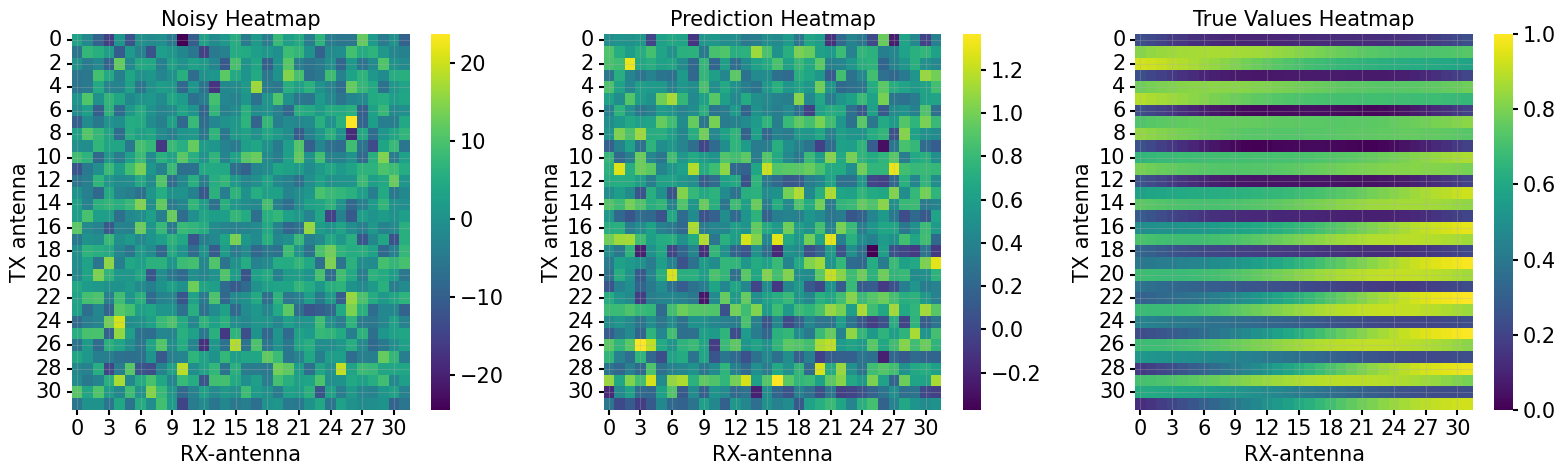

In [92]:
# plot predictions
if deepmimo:
    noisy_sample = tensors['test'][0][5]
    pred_sample = y_preds_MLP['preds'][5]
    true_sample = tensors['test'][1][5]
    mlp_model.plot_deepmimo_with_noise(true_sample=true_sample, pred_sample=pred_sample,noisy_sample=noisy_sample, save=False)
else:
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

saved loss to  ./results/MLP/deepmimo-gaussian_-20.444/loss.png


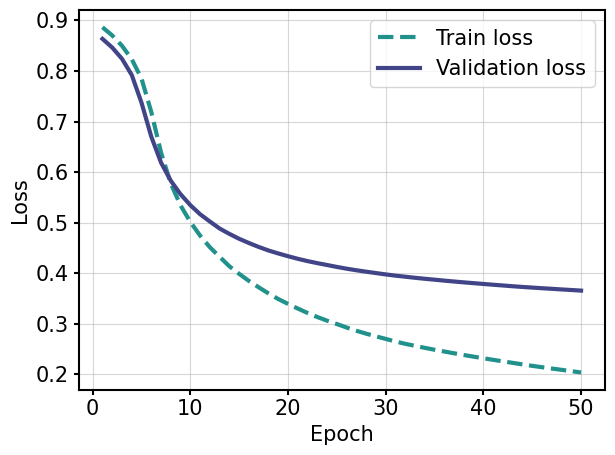

Model parameters saved to ./results/MLP/deepmimo-gaussian_-20.444/model_params.txt


In [93]:

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)
# plot loss
#mlp_model.write_params_to_file(results)